<a href="https://colab.research.google.com/github/kappagl/DLExamen1Parte2/blob/main/Examen1p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/m3ex02-data.zip

In [2]:
#Imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import numpy as np
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Que configuracion tienes
device

device(type='cuda')

En el caso de CDataset no usamos ImageFolder de pytorch directo y tuvimos que abrir 1 a 1 las imagenes puesto que esperaria un acomodo de folder distintos como:


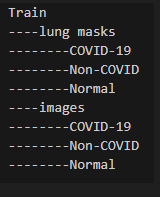

Al tener un acomodo distinto, se tenia que ir imagen por imagen agrupandola por su mascara para ser capaces de agregar el etiquetado teniendo (tensor_imagen,tensor_mask,label), se aplico tambien una interpolacion ya que al aplicar Resize en el caso de las mascaras, la segmentacion debe ser muy precisa ya que cierto numero en el pixel corresponde a determinada caracteristica por ejemplo fondo=0, la interpolacion al mas cercano hace que se omita la introduccion de otros valores que pueda afectar a la segmentacion ya realizada

In [4]:
class CDataset(Dataset):
    def __init__(self,dirlist):
        self.samples = []
        self.label_to_index = {"COVID-19": 0, "Non-COVID": 1, "Normal": 2} #Encoding labels haciendo mapeo
        self.transform = {
            'image': transforms.Compose([
                transforms.Resize([256,256]),
                transforms.ToTensor(),
            ]),
            'mask': transforms.Compose([
                transforms.Resize([256,256],interpolation=transforms.InterpolationMode.NEAREST),#Aplicas interpolacion a las mascaras para no meter ruido, ya que en estas imagenes se asigna un numero a determinada caracteristica y aplicar cualquier interpolacion puede hacer que se interprete como un valor que originalmente no era
                transforms.ToTensor(),
            ])
        }
        for imagedirs, maskdirs, label in dirlist:
            images = sorted(os.listdir(imagedirs))
            for img in images:
                self.samples.append((os.path.join(imagedirs, img), os.path.join(maskdirs, img), label))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_path, mask_path, label_ = self.samples[idx]
        image = self.transform['image'](Image.open(img_path))
        mask = self.transform['mask'](Image.open(mask_path))
        label = self.label_to_index[label_]
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image, mask, label_tensor

Despues de crear el Dataset se pasa ese dataset al DataLoader, para asi poder agregar un batch size y facilitar la iteracion sobre el conjunto de datos de entrenamiento

In [5]:
trainpath = "/content/m3ex02-data/Train"
trainlist= [(trainpath+"/COVID-19/images",trainpath+"/COVID-19/lung masks","COVID-19"),(trainpath+"/Non-COVID/images",trainpath+"/Non-COVID/lung masks","Non-COVID"),(trainpath+"/Normal/images",trainpath+"/Normal/lung masks","Normal")]
valpath = "/content/m3ex02-data/Val"
vallist= [(valpath+"/COVID-19/images",valpath+"/COVID-19/lung masks","COVID-19"),(valpath+"/Non-COVID/images",valpath+"/Non-COVID/lung masks","Non-COVID"),(valpath+"/Normal/images",valpath+"/Normal/lung masks","Normal")]
testpath = "/content/m3ex02-data/Test"
testlist= [(testpath+"/COVID-19/images",testpath+"/COVID-19/lung masks","COVID-19"),(testpath+"/Non-COVID/images",testpath+"/Non-COVID/lung masks","Non-COVID"),(testpath+"/Normal/images",testpath+"/Normal/lung masks","Normal")]
dloadertrain = torch.utils.data.DataLoader(dataset=CDataset(trainlist), batch_size=30, shuffle=True, num_workers=0)
dloadertest = torch.utils.data.DataLoader(dataset=CDataset(testlist), batch_size=30, shuffle=True, num_workers=0)
dloaderval = torch.utils.data.DataLoader(dataset=CDataset(vallist), batch_size=30, shuffle=True, num_workers=0)

En el modelo se hizo un Resnet con un Unet, sin usar el Unet preentrenado porque me dio muchos problemas, principalmente porque estaba entrenado con imagenes a color y en este caso estan en escalas de grises a un canal  
Para poder utilizar el Resnet50 tuve que modificar la primera capa ya que iba a recibir imagenes en escala de grises  
Para poder unir el Resnet50 con el Unet se debe tomar el primero como encoder y el segundo como decoder  
Unet toma las caracteristicas extraidas de Resnet (resnet_features) y las procesa mediante capas de convolucion transpuesta  
Se retorna tanto la mascara como el label  

In [6]:
class ResnetUnet(nn.Module):

  def __init__(self):
      #En este caso si se quiere combinar 2 modelos se debe usar uno como encoder y otro como decoder
      #Resnet18
      super().__init__()
      self.resnet = models.resnet50(pretrained=True) #inicializando el modelo preentrenado
      self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # Modificamos la primera capa para que acepte imagenes en escalad e grises
      self.resnet_features = nn.Sequential(*list(self.resnet.children())[:-2]) #Tomamos los features pero se quita la capa de salida para que podamos agregar unet como utilma capa y poder hacer la combinacion
      # Al tener imagenes en escala de grises no utilice el unet preentrenado sin embargo se agreaga un unet simplificado
      self.upconv = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
        )
      self.conv_last = nn.Conv2d(64, 1, 1)
      self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
      self.fc = nn.Linear(64, 3)
  def forward(self, x):
        # Extraer características con ResNet usandolo como encoder
        features = self.resnet_features(x)
        # Pasar las características a través de U-Net y usandolo como decorder
        upconvfeatures = self.upconv(features)
        mask  = nn.Sigmoid()(self.conv_last(upconvfeatures))

        pool = self.avgpool(upconvfeatures)
        flatten = torch.flatten(pool, 1)
        label = nn.Softmax(dim=1)(self.fc(flatten))
        return mask,label

En esta parte final se entrena, valida y prueba el codigo, se usan 2 Criterion ya que tenemos segmentacion y validacion y para sacar la perdida total se suman ambos

In [7]:
# Creamos la funcion para evaluar, validar y probar el modelo
def fit(train,test,val,model,criterions,criterionc,optimizer,epochs):
    #Al ser segmentacion y clasificacion se calcularan diferentes metricas
    model.to("cuda")
    for epoch in range(epochs):
        #Entrenamiento
        model.train()
        train_loss = 0.0
        train_accuracy = []
        for images,masks,labels in train:
            images,masks,labels = images.to("cuda"),masks.to("cuda"),labels.to("cuda")
            optimizer.zero_grad()
            maskout,labelout = model(images)
            loss = criterions(maskout, masks) + criterionc(labelout,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted_labels = torch.max(labelout, 1)
            accuracy = (predicted_labels == labels).float().mean()
            train_accuracy.append(accuracy)
        # Validación
        val_loss = 0.0
        val_accuracy = []
        model.eval()
        with torch.no_grad():
            for valimages,valmask, vallabels in val:
                valimages,valmask, vallabels = valimages.to("cuda"),valmask.to("cuda"), vallabels.to("cuda")
                valmaskout,vallabelout = model(valimages)
                val_loss += criterions(valmaskout, valmask).item() + criterionc(vallabelout,vallabels).item()
                _, predicted_labels = torch.max(vallabelout, 1)
                accuracyval = (predicted_labels == vallabels).float().mean()
                val_accuracy.append(accuracyval)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train)}, Train Accuracy: {sum(train_accuracy) / len(train_accuracy)}, Val Loss: {val_loss / len(val)}, Val Accuracy: {sum(val_accuracy) / len(val_accuracy)}')

    # Test
    model.eval()
    test_accuracy = []
    with torch.no_grad():
        for testimages,testmask, testlabels in test:
            testimages,testmask, testlabels =testimages.to("cuda"),testmask.to("cuda"), testlabels.to("cuda")
            _,testlabelout = model(testimages)
            _,predicted_labels = torch.max(testlabelout, 1)
            testaccuracy = (predicted_labels == testlabels).float().mean()
            test_accuracy.append(testaccuracy)

    print(f'Test Accuracy: {sum(test_accuracy) / len(test_accuracy)}')


model = ResnetUnet()
criterions = nn.BCELoss()
criterionc = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
fit(dloadertrain,dloadertest,dloaderval,model,criterions,criterionc,optimizer,10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


Epoch 1, Train Loss: 1.2313696600455606, Train Accuracy: 0.49755099415779114, Val Loss: 1.076038876291138, Val Accuracy: 0.5894482135772705
Epoch 2, Train Loss: 1.0810796645629472, Train Accuracy: 0.5838956236839294, Val Loss: 1.077518243404383, Val Accuracy: 0.5869999527931213
Epoch 3, Train Loss: 1.049110832052995, Train Accuracy: 0.6170908808708191, Val Loss: 0.9884608463687792, Val Accuracy: 0.669179379940033
Epoch 4, Train Loss: 1.0688229524298927, Train Accuracy: 0.5753875970840454, Val Loss: 1.0786592377071882, Val Accuracy: 0.5497886538505554
Epoch 5, Train Loss: 0.957478167273063, Train Accuracy: 0.69667649269104, Val Loss: 1.0150091676092938, Val Accuracy: 0.6451951861381531
Epoch 6, Train Loss: 0.9139798278637354, Train Accuracy: 0.7356170415878296, Val Loss: 1.007282887415662, Val Accuracy: 0.6539914011955261
Epoch 7, Train Loss: 0.9009072819302754, Train Accuracy: 0.7437660694122314, Val Loss: 0.9084743463449715, Val Accuracy: 0.7353049516677856
Epoch 8, Train Loss: 0.8834

In [11]:
savepath = "/content/drive/MyDrive/Colab Notebooks/ExamenKarlaGarcia/model_resunet.pth"
torch.save(model.state_dict(), savepath)